Iniciando análisis de trading cuántico con datos horarios de 2 años...

Analizando trading horario para EURUSD=X...
Descargando datos horarios para EURUSD=X...


[*********************100%***********************]  1 of 1 completed


Datos horarios obtenidos: 12366 horas
Características calculadas: 7
Columnas disponibles: ['returns', 'range', 'volatility', 'momentum', 'hour_sin', 'hour_cos', 'deviation']
Datos procesados finales: 12342 registros
Iniciando backtesting horario...
Procesado 100/12342 intervalos
Procesado 200/12342 intervalos
Procesado 300/12342 intervalos
Procesado 400/12342 intervalos
Procesado 500/12342 intervalos
Procesado 600/12342 intervalos
Procesado 700/12342 intervalos
Procesado 800/12342 intervalos
Procesado 900/12342 intervalos
Procesado 1000/12342 intervalos
Procesado 1100/12342 intervalos
Procesado 1200/12342 intervalos
Procesado 1300/12342 intervalos
Procesado 1400/12342 intervalos
Procesado 1500/12342 intervalos
Procesado 1600/12342 intervalos
Procesado 1700/12342 intervalos
Procesado 1800/12342 intervalos
Procesado 1900/12342 intervalos
Procesado 2000/12342 intervalos
Procesado 2100/12342 intervalos
Procesado 2200/12342 intervalos
Procesado 2300/12342 intervalos
Procesado 2400/12342 int

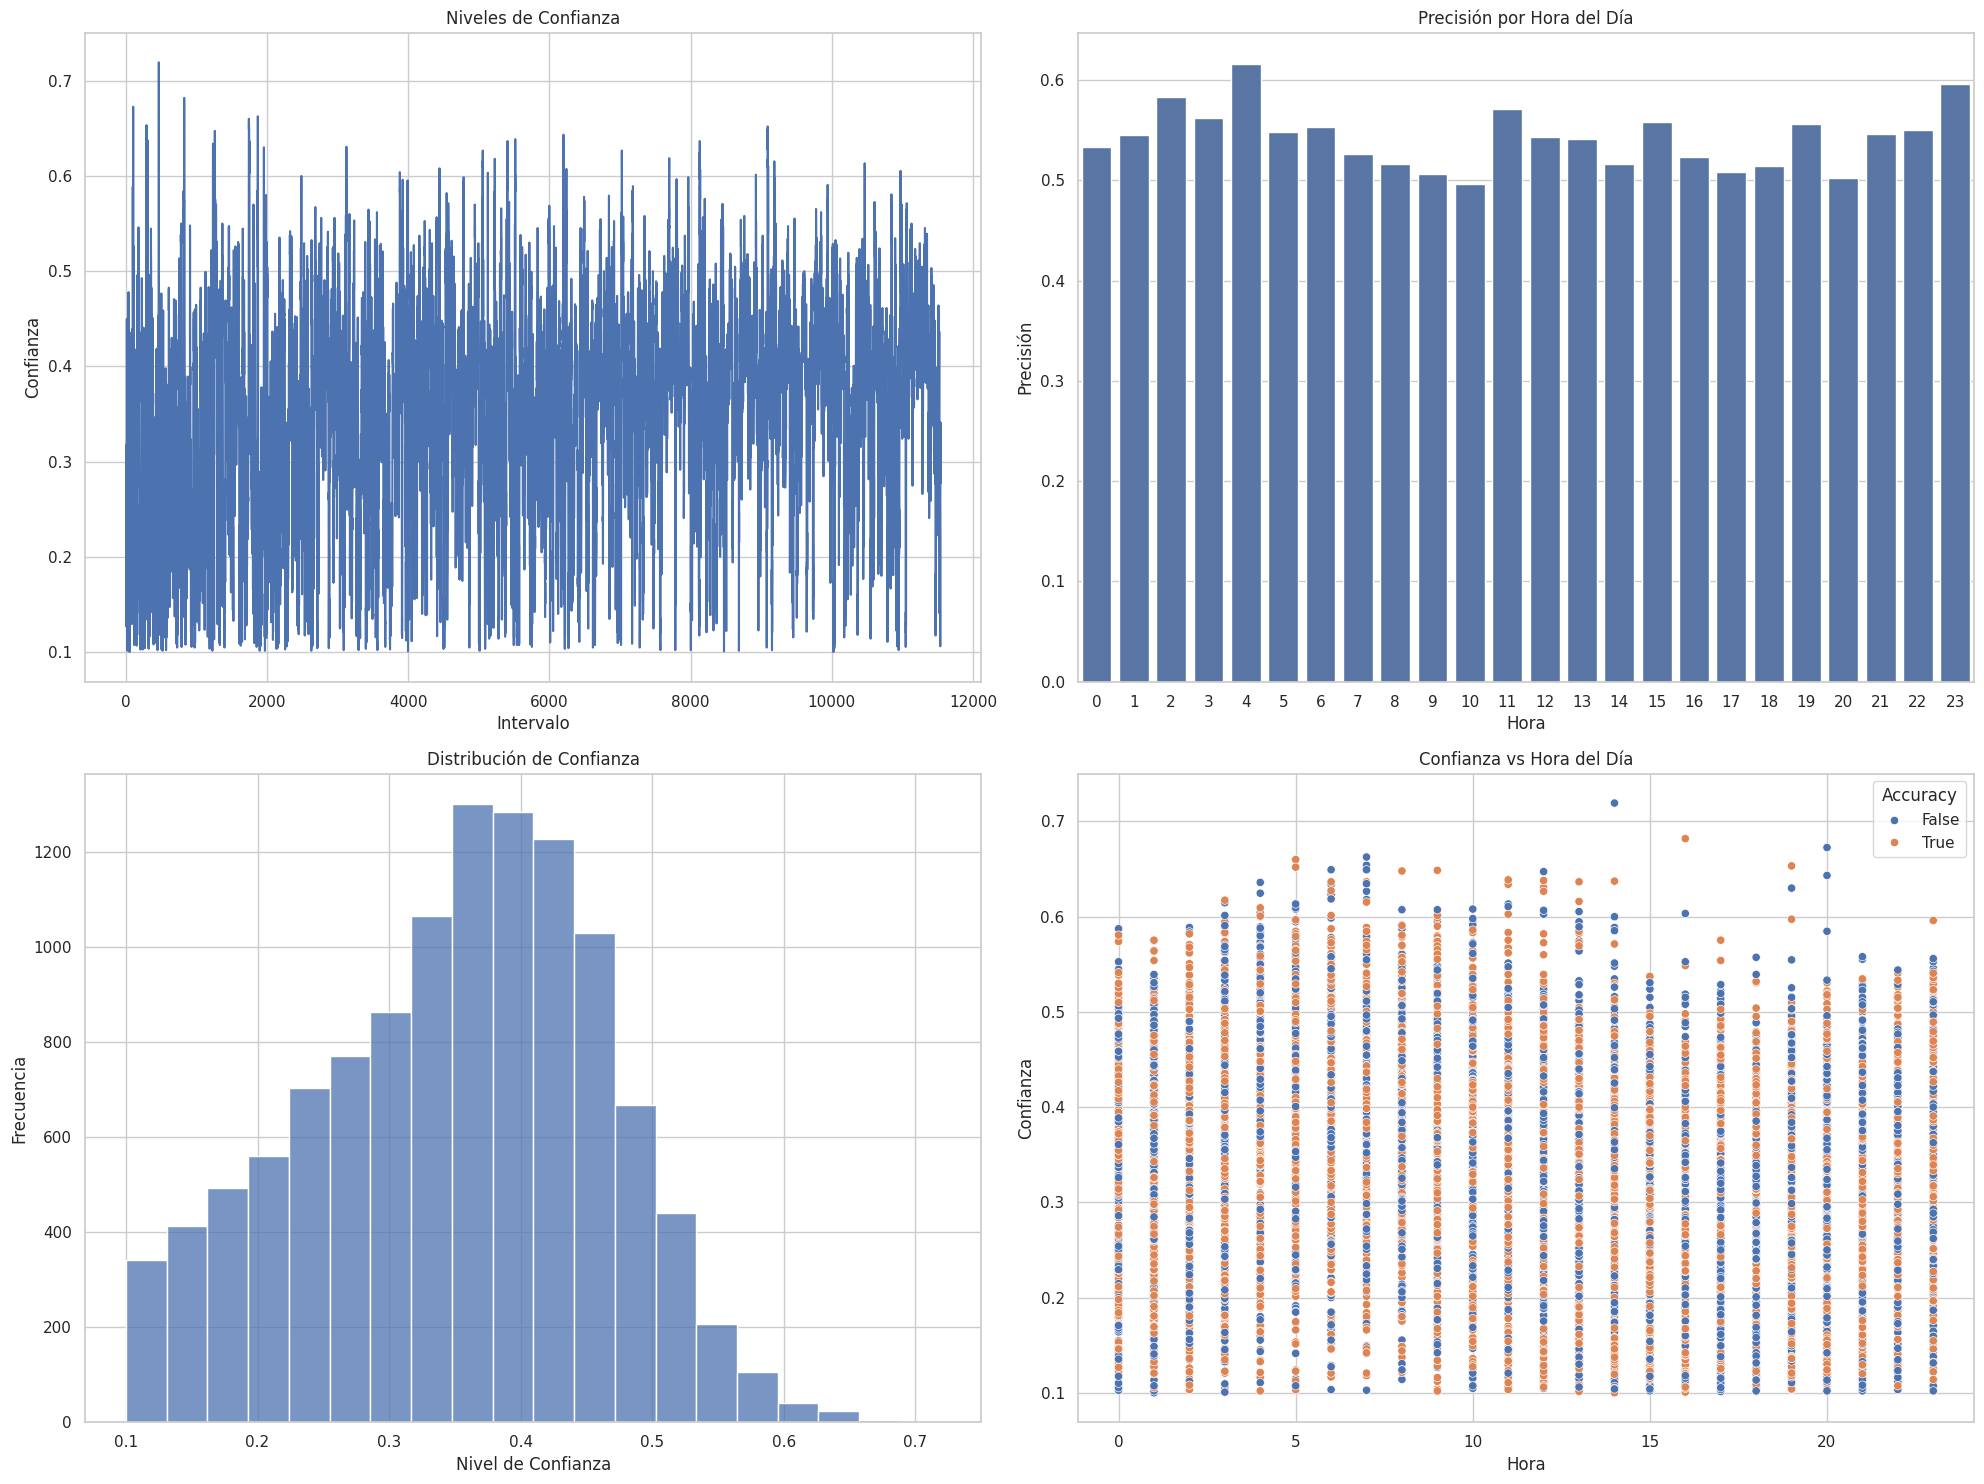

In [ ]:
# CELDA 1 - Instalación
!pip install qiskit==0.44.0
!pip install yfinance pandas numpy scikit-learn matplotlib seaborn

# CELDA 2 - Importaciones
import numpy as np
import pandas as pd
import yfinance as yf
from qiskit import QuantumCircuit, execute, BasicAer
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Configuración
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [15, 7]

# CELDA 1 y 2 igual que antes

# CELDA 1 y 2 igual que antes

# CELDA 3 - Clase con manejo de series corregido
class HourlyQuantumForex:
    def __init__(self):
        self.n_qubits = 3
        self.simulator = BasicAer.get_backend('qasm_simulator')
        self.scaler = MinMaxScaler()
        self.min_confidence = 0.1

    def calculate_features(self, data):
        """Calcula características con manejo correcto de series temporales"""
        features = pd.DataFrame(index=data.index)

        # Características básicas
        returns = data['Close'].pct_change()
        features['returns'] = returns
        features['range'] = (data['High'] - data['Low']) / data['Close']

        # Volatilidad y momentum
        features['volatility'] = returns.rolling(window=12).std()
        features['momentum'] = returns.rolling(window=24).mean()

        # Características temporales
        features['hour_sin'] = np.sin(2 * np.pi * data.index.hour / 24)
        features['hour_cos'] = np.cos(2 * np.pi * data.index.hour / 24)

        # Media móvil y desviación
        sma = data['Close'].rolling(window=24).mean()
        features['deviation'] = (data['Close'] - sma) / sma

        return features

    def prepare_data(self, symbol='EURUSD=X'):
        print(f"Descargando datos horarios para {symbol}...")

        try:
            # Descarga y verifica datos
            data = yf.download(symbol, period='2y', interval='1h')

            if len(data) == 0:
                raise ValueError("No se obtuvieron datos")

            print(f"Datos horarios obtenidos: {len(data)} horas")

            # Calcular características
            features = self.calculate_features(data)

            # Eliminar valores nulos
            features = features.replace([np.inf, -np.inf], np.nan)
            features = features.dropna()

            print(f"Características calculadas: {features.shape[1]}")
            print("Columnas disponibles:", features.columns.tolist())

            # Separar returns antes de escalar
            returns = features.pop('returns')

            # Escalar el resto de características
            scaled_features = self.scaler.fit_transform(features)

            print(f"Datos procesados finales: {len(features)} registros")

            return scaled_features, features.index, returns

        except Exception as e:
            print(f"Error al procesar datos: {e}")
            traceback.print_exc()
            return None, None, None

    def create_circuit(self, input_data):
        """Circuito cuántico con manejo de datos mejorado"""
        qc = QuantumCircuit(self.n_qubits, self.n_qubits)

        try:
            # Asegurar que los datos son numéricos y finitos
            input_data = np.array(input_data, dtype=float)
            input_data = np.nan_to_num(input_data, 0.0)  # Reemplazar NaN con 0

            # Codificación
            for i in range(self.n_qubits):
                feature_idx = i % len(input_data)
                angle = np.clip(np.pi * input_data[feature_idx], -2*np.pi, 2*np.pi)
                qc.ry(angle, i)

            # Entrelazamiento
            for i in range(self.n_qubits - 1):
                qc.cx(i, i + 1)
            qc.cx(self.n_qubits - 1, 0)

            # Rotaciones finales
            for i in range(self.n_qubits):
                qc.ry(np.pi/4, i)

            qc.measure_all()
            return qc

        except Exception as e:
            print(f"Error en circuito: {e}")
            return None

    def predict(self, input_data, shots=1000):
        """Predicción con mejor manejo de errores"""
        try:
            qc = self.create_circuit(input_data)
            if qc is None:
                return None, 0.0

            job = execute(qc, self.simulator, shots=shots)
            result = job.result()
            counts = result.get_counts(qc)

            # Sistema de votación mejorado
            total_votes = float(sum(counts.values()))
            weighted_votes = float(sum(count * state.count('1')
                                    for state, count in counts.items()))

            prediction_score = weighted_votes / (total_votes * self.n_qubits)
            prediction = bool(prediction_score > 0.5)
            confidence = float(2 * abs(prediction_score - 0.5))

            return prediction, confidence

        except Exception as e:
            print(f"Error en predicción: {e}")
            return None, 0.0

    def backtest(self, symbol='EURUSD=X'):
        """Backtesting con mejor manejo de datos"""
        try:
            data, dates, returns = self.prepare_data(symbol)

            if data is None:
                return None

            predictions = []
            actual_returns = []
            confidence_scores = []
            hours = []

            print("Iniciando backtesting horario...")
            for i in range(1, len(data)):
                if i % 100 == 0:
                    print(f"Procesado {i}/{len(data)} intervalos")

                pred, conf = self.predict(data[i-1])

                if pred is not None and conf > self.min_confidence:
                    predictions.append(bool(pred))
                    confidence_scores.append(float(conf))
                    actual_returns.append(bool(returns.iloc[i] > 0))
                    hours.append(int(dates[i].hour))

            if len(predictions) > 0:
                accuracy = float(np.mean([p == a for p, a in zip(predictions, actual_returns)]))

                return {
                    'accuracy': accuracy,
                    'predictions': predictions,
                    'actual': actual_returns,
                    'confidence': confidence_scores,
                    'hours': hours,
                    'dates': dates[1:len(predictions)+1]
                }
            else:
                print("No se generaron predicciones suficientes")
                return None

        except Exception as e:
            print(f"Error en backtesting: {e}")
            traceback.print_exc()
            return None


# CELDA 4 - Análisis horario corregido
def analyze_hourly_trading(symbol='EURUSD=X'):  # Eliminamos el parámetro period
    trader = HourlyQuantumForex()
    print(f"\nAnalizando trading horario para {symbol}...")

    result = trader.backtest(symbol)  # Ya no pasamos el period

    if result and len(result['predictions']) > 0:
        print(f"\nResultados para {symbol}:")
        print(f"Precisión global: {result['accuracy']:.2%}")
        print(f"Total predicciones: {len(result['predictions'])}")

        # Análisis por hora del día
        df_results = pd.DataFrame({
            'Hour': result['hours'],
            'Accuracy': [p == a for p, a in zip(result['predictions'], result['actual'])],
            'Confidence': result['confidence']
        })

        # Precisión por hora
        hourly_accuracy = df_results.groupby('Hour')['Accuracy'].mean()

        # Visualizaciones
        fig, axes = plt.subplots(2, 2, figsize=(20, 15))

        # 1. Niveles de confianza en el tiempo
        sns.lineplot(data=result['confidence'], ax=axes[0,0])
        axes[0,0].set_title('Niveles de Confianza')
        axes[0,0].set_xlabel('Intervalo')
        axes[0,0].set_ylabel('Confianza')

        # 2. Precisión por hora del día
        sns.barplot(x=hourly_accuracy.index, y=hourly_accuracy.values, ax=axes[0,1])
        axes[0,1].set_title('Precisión por Hora del Día')
        axes[0,1].set_xlabel('Hora')
        axes[0,1].set_ylabel('Precisión')

        # 3. Distribución de confianza
        sns.histplot(data=result['confidence'], bins=20, ax=axes[1,0])
        axes[1,0].set_title('Distribución de Confianza')
        axes[1,0].set_xlabel('Nivel de Confianza')
        axes[1,0].set_ylabel('Frecuencia')

        # 4. Scatter plot de confianza vs hora
        sns.scatterplot(data=df_results, x='Hour', y='Confidence',
                       hue='Accuracy', ax=axes[1,1])
        axes[1,1].set_title('Confianza vs Hora del Día')
        axes[1,1].set_xlabel('Hora')
        axes[1,1].set_ylabel('Confianza')

        plt.tight_layout()
        plt.show()

        # Estadísticas detalladas
        print("\nEstadísticas del modelo:")
        print(f"Confianza promedio: {np.mean(result['confidence']):.2%}")
        print(f"Señales alcistas: {sum(result['predictions'])} ({sum(result['predictions'])/len(result['predictions']):.1%})")
        print(f"Señales bajistas: {len(result['predictions'])-sum(result['predictions'])} ({1-sum(result['predictions'])/len(result['predictions']):.1%})")

        # Mejores horas de trading
        best_hours = hourly_accuracy.nlargest(3)
        print("\nMejores horas para trading:")
        for hour, acc in best_hours.items():
            print(f"Hora {hour:02d}:00 - Precisión: {acc:.2%}")

    else:
        print("No se pudieron obtener resultados válidos")

# CELDA 5 - Ejecución
if __name__ == "__main__":
    print("Iniciando análisis de trading cuántico con datos horarios de 2 años...")
    analyze_hourly_trading('EURUSD=X')  # Ya no pasamos el period